# AAND BCI - Exercise Sheet #02

#### Name: Luke Longren

In [1]:
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse
import os

import bci_minitoolbox as bci

In [2]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')
plt.rcParams.update({'font.size': 16})
plt.rcParams["figure.figsize"] = (10, 5)

## Preparation: Loading Data

In [3]:
fname = 'erp_hexVPsag.npz'
cnt, fs, clab, mnt, mrk_pos, mrk_class, mrk_className = bci.load_data(fname)
"""
cnt: multi-channel timeseries (channels x samples), unit [uV] 
fs: sampling frequency [Hz]
clab: channel names (channels)
mnt: channel coordinates (channels x 2)
mrk_pos: marker positions (samples)
mrk_class: marker to class (0, 1)
mrk_className: class name to classes
"""
print(np.shape(cnt), ', shape of the timeseries data')

(55, 38710) , shape of the timeseries data


## Exercise 1: Plotting ERPs  (2 points)

Plot the average ERPs corresponding to *target* and *nontarget* stimuli in the time interval -100 to 1000 ms for the channels Cz and PO7.
In order to make the curves look reasonable, a so called 'baseline correction' should be performed: for each channel and trial, calculate the average across the prestimulus time interval -100 to 0 ms. This results in one value per channel and trial. Subtract this 'baseline' value from each (single channel/single trial) time course. 
The function `baseline` is provided in the `bci_minitoolbox`. It is recommended to have a look at the code.

In [4]:
"""average ERPs for target and nontarget stimuli"""
chans = ['Cz', 'PO7']
idx = [clab.index(chans[0]), clab.index(chans[1])]
ival = [-100, 1000]
ref_ival = [-100, 0]

# couldn't find a way to use mrk_className, so just made two index arrays:
target_idx = np.array([], dtype=int)
nontarget_idx = np.array([], dtype=int)
for i in range(len(mrk_class)):
    if mrk_class[i] == 0:  # here, I assume 0 stands for target
        target_idx = np.append(target_idx, i) 
    else:
        nontarget_idx = np.append(nontarget_idx, i) 
        
# first determine the epochs for target stimuli
epo, epo_t = bci.makeepochs(X=cnt, fs=fs, mrk_pos=mrk_pos[target_idx], ival=ival)
# now find the baseline value
baseline_epo = bci.baseline(epo=epo, epo_t=epo_t, ref_ival=ref_ival)

# do the same for the nontarget stimuli  
epo_nontarget, _ = bci.makeepochs(X=cnt, fs=fs, mrk_pos=mrk_pos[nontarget_idx], ival=ival)
baseline_epo_nontarget = bci.baseline(epo=epo_nontarget, epo_t=epo_t, ref_ival=ref_ival)

print(np.shape(epo_t), ', shape of the epoch time points, [ms]')
print('target:', np.shape(baseline_epo), ' nontarget:', np.shape(baseline_epo_nontarget), ', (samples x channels x epochs)')

(111,) , shape of the epoch time points, [ms]
target: (111, 55, 218)  nontarget: (111, 55, 982) , (samples x channels x epochs)


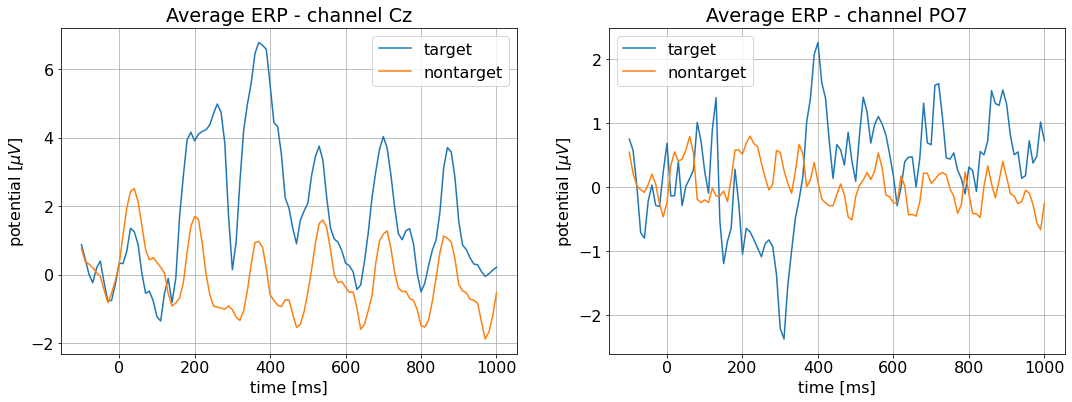

In [5]:
# plot the average ERPs with baseline subtracted
fig, axs = plt.subplots(1,2, figsize=(18,6))
axs[0].plot(epo_t, np.mean(baseline_epo[:,idx[0]], axis=1), label='target')
axs[1].plot(epo_t, np.mean(baseline_epo[:,idx[1]], axis=1), label='target')
axs[0].plot(epo_t, np.mean(baseline_epo_nontarget[:,idx[0]], axis=1), label='nontarget')
axs[1].plot(epo_t, np.mean(baseline_epo_nontarget[:,idx[1]], axis=1), label='nontarget')
axs[0].set_title('Average ERP - channel Cz'), axs[1].set_title('Average ERP - channel PO7')
axs[0].set_ylabel('potential [$\mu V$]'), axs[1].set_ylabel('potential [$\mu V$]')
axs[0].set_xlabel('time [ms]'), axs[1].set_xlabel('time [ms]')
axs[0].legend(), axs[1].legend()
axs[0].grid(), axs[1].grid()
plt.tight_layout
plt.show()

## Exercise 2: Scatter Plot of 2D Features  (3 points + 1 bonus)

Make a scatter plot of the two distributions - *targets* and *nontargets*, one dot for each trial. On the `x`-axis, plot the value of channel Cz at `t` = 380 ms, and at the `y`-axis the value of PO7 at `t` = 320 ms. Draw for both distributions the two principal axes, with the lengths of the axes being the standard deviation of the data in
that direction. 
**Bonus:** Draw also the corresponding ellipses. You can get that with a transformation of the unit circle.

In [6]:
"""plot channel distributions at given time values with principal axes and ellipses"""
time_points = [380, 320]
# determine the indices corresponding the the given time points
time_idx = [np.where(epo_t == time_points[0]), np.where(epo_t == time_points[1])]
target_dist = np.array([baseline_epo[time_idx[0], idx[0]][0,0,:], baseline_epo[time_idx[1], idx[1]][0,0,:]])
nontarget_dist = np.array([baseline_epo_nontarget[time_idx[0], idx[0]][0,0,:], baseline_epo_nontarget[time_idx[1], idx[1]][0,0,:]])
print(np.shape(target_dist), np.shape(nontarget_dist))

(2, 218) (2, 982)


In [7]:
# find the principal axes of the distributions
def PCA(data):
    cov = np.cov(data, rowvar=True)  # measure covariances, construct the matrix
    eigenvalues, eigenvectors = np.linalg.eigh(cov)  # eigenvalue decomposition
    return cov, eigenvalues, eigenvectors

cov_target, w_target, v_target = PCA(target_dist)
cov_nontarget, w_nontarget, v_nontarget = PCA(nontarget_dist)
target_mean = [np.mean(target_dist[0]), np.mean(target_dist[1])]
nontarget_mean = [np.mean(nontarget_dist[0]), np.mean(nontarget_dist[1])]

# scale the length to the std of the data in that direction
std_target = np.std(target_dist, axis=1)  # std of data
angle_v_target = np.arctan(v_target[1]/v_target[0])  # angle of vector
scaled_v_target = np.array([std_target[0] * np.cos(angle_v_target), std_target[1] * np.sin(angle_v_target)])
# do the same for the nontarget data
std_nontarget = np.std(nontarget_dist, axis=1)  # std of data
angle_v_nontarget = np.arctan(v_nontarget[1]/v_nontarget[0])  # angle of vector
scaled_v_nontarget = np.array([std_nontarget[0] * np.cos(angle_v_nontarget), std_nontarget[1] * np.sin(angle_v_nontarget)])

# test to ensure we did that correctly
print(angle_v_target[0]-angle_v_target[1]+(np.pi/2), ', difference in vector angle, plus pi/4')  # confirms that they are a right angle
print(np.std(target_dist, axis=1), ', standard deviation of the data set')
print(np.linalg.norm(scaled_v_target, axis=1), ', magnitude of the principal axes')

0.0 , difference in vector angle, plus pi/4
[11.98876731  8.04809872] , standard deviation of the data set
[11.98876731  8.04809872] , magnitude of the principal axes


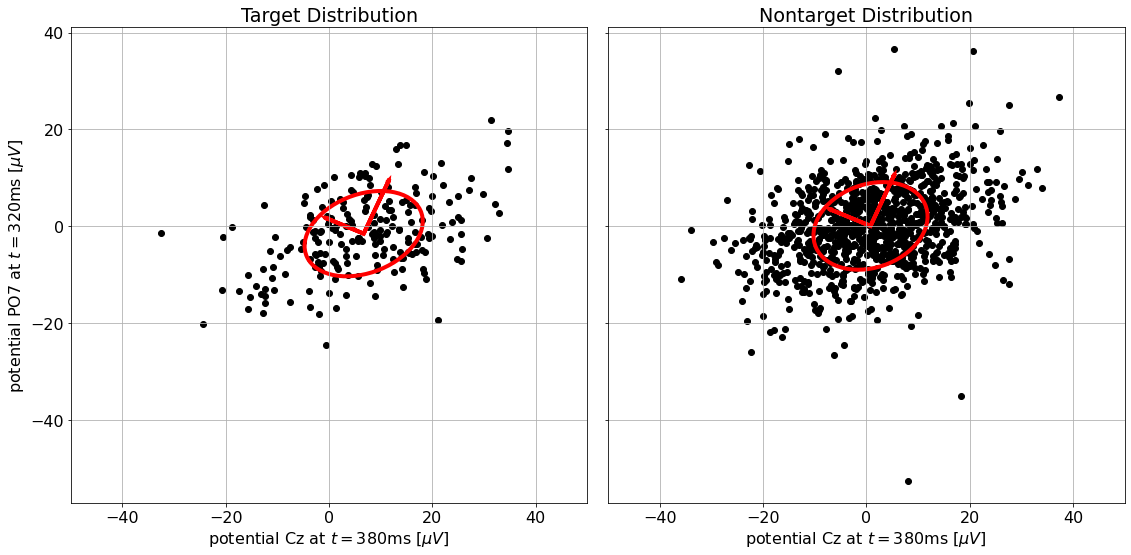

In [8]:
# create the ellipses for both data sets
ellipse_target = Ellipse((target_mean[0], target_mean[1]), 
                         2*std_target[0], 2*std_target[1], angle_v_target[1]*180/np.pi, fill=False, ec='r', lw=4)
ellipse_nontarget = Ellipse((nontarget_mean[0], nontarget_mean[1]), 
                            2*std_nontarget[0], 2*std_nontarget[1], angle_v_nontarget[1]*180/np.pi, fill=False, ec='r', lw=4)

fig, axs = plt.subplots(1,2, figsize=(16,8), sharex=True, sharey=True)
axs[0].scatter(target_dist[0], target_dist[1], label='target', c='k')
axs[0].arrow(target_mean[0], target_mean[1], scaled_v_target[0,0], scaled_v_target[0,1], label='principle', color='r', linewidth=4)
axs[0].arrow(target_mean[0], target_mean[1], scaled_v_target[1,0], scaled_v_target[1,1], label='principle', color='r', linewidth=4)
axs[0].add_patch(ellipse_target)

axs[1].scatter(nontarget_dist[0], nontarget_dist[1], label='nontarget', c='k')
axs[1].arrow(nontarget_mean[0], nontarget_mean[1], scaled_v_nontarget[0,0], scaled_v_nontarget[0,1], label='principle', color='r', linewidth=4)
axs[1].arrow(nontarget_mean[0], nontarget_mean[1], scaled_v_nontarget[1,0], scaled_v_nontarget[1,1], label='principle', color='r', linewidth=4)
axs[1].add_patch(ellipse_nontarget)

axs[0].set_title('Target Distribution'), axs[1].set_title('Nontarget Distribution')
axs[0].set_xlabel('potential Cz at $t=380$ms [$\mu V$]'), axs[1].set_xlabel('potential Cz at $t=380$ms [$\mu V$]')
axs[0].set_ylabel('potential PO7 at $t=320$ms [$\mu V$]')
axs[0].grid(), axs[1].grid()
axs[0].set_xlim(-50,50)
plt.tight_layout()
plt.show()

## Exercise 3: Scalp Topographies of ERPs  (2 points)

Calculate the average potential separately for the classes *target* and *non-target* in the following time intervals [ms]: [160 200], [230 260], [300 320], and [380 430]. (This involves averaging over all trials of the respective class and averaging over all sample points in the respective time interval.)
Visualize the result as scalp topographies using the function `bci.scalpmap`, i.e., 4 maps for each class.
**Note:** In order to make the maps look reasonable, do a *baseline correction* as in the previous task. To make the maps comparable, use a common scale for the colorbar (see help of `scalpmap`). For ERPs, a range should be chosen for the colormap, which is symmetric around 0.

In [9]:
"""create scalp maps of the ERPs over certain time intervals"""
print(np.shape(baseline_epo), ', target: (samples x channels x epochs)')
print(np.shape(baseline_epo_nontarget), ', nontarget: (samples x channels x epochs)')

(111, 55, 218) , target: (samples x channels x epochs)
(111, 55, 982) , nontarget: (samples x channels x epochs)


In [10]:
# first let's average over all trials for each channel
trial_baseline_epo = np.mean(baseline_epo, axis=2)
trial_baseline_epo_nontarget = np.mean(baseline_epo_nontarget, axis=2)
print(np.shape(trial_baseline_epo), ', target: (samples x channels)')
print(np.shape(trial_baseline_epo_nontarget), ', nontarget: (samples x channels)')

(111, 55) , target: (samples x channels)
(111, 55) , nontarget: (samples x channels)


In [11]:
# next we shall average over the given time intervals
ival = [[160, 200], [230, 260], [300, 320], [380, 430]]

cbar_range = 4  # scale for the colorbar, symmetric around 0
fig = plt.figure(figsize=(7,7))
count = 0
for ival in ival:
    # get the correct index values for the time steps
    epo_t_idx = np.where(epo_t < ival[0], np.nan, epo_t) 
    epo_t_idx = np.where(epo_t > ival[1], np.nan, epo_t_idx)
    epo_t_idx = [i for i in range(len(epo_t_idx)) if ~np.isnan(epo_t_idx[i])]
    
    # determine the average over the time index values
    time_baseline_epo = np.mean(trial_baseline_epo[epo_t_idx], axis=0)
    time_baseline_epo_nontarget = np.mean(trial_baseline_epo_nontarget[epo_t_idx], axis=0)

    # plot the scalp maps for each time interval
    count += 1
    bci.scalpmap(mnt=mnt, v=time_baseline_epo, clim=[-cbar_range, cbar_range], cb_label='')
    plt.savefig('subplot_target_{0}.png'.format(count))
    plt.clf()

    bci.scalpmap(mnt=mnt, v=time_baseline_epo_nontarget, clim=[-cbar_range, cbar_range], cb_label='')
    plt.savefig('subplot_nontarget_{0}.png'.format(count))
    plt.clf()

<Figure size 504x504 with 0 Axes>

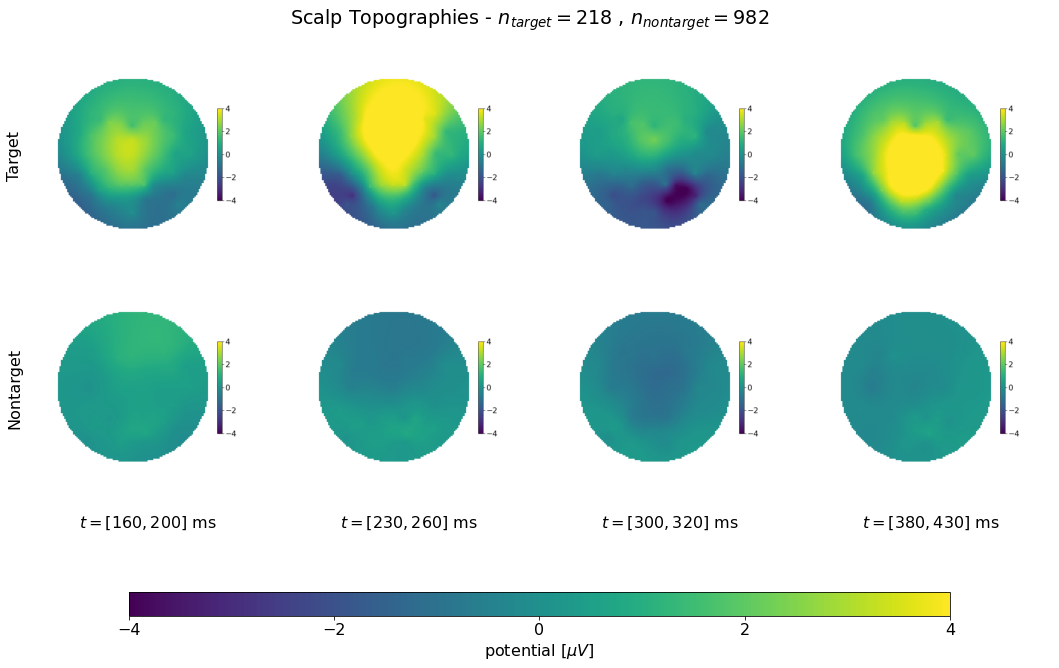

In [12]:
ival = [[160, 200], [230, 260], [300, 320], [380, 430]]

fig, axs = plt.subplots(2, 4, figsize=(15, 10), squeeze=True)
for i in range(4):
    target = plt.imread('subplot_target_{0}.png'.format(i+1))
    nontarget = plt.imread('subplot_nontarget_{0}.png'.format(i+1))
    # delete the images after using them
    os.remove('subplot_target_{0}.png'.format(i+1)), os.remove('subplot_nontarget_{0}.png'.format(i+1))
    axs[0,i].imshow(target)
    axs[1,i].imshow(nontarget)
    # just plotting stuff below
    axs[0,i].get_xaxis().set_ticks([]), axs[1,i].get_xaxis().set_ticks([])
    axs[0,i].get_yaxis().set_ticks([]), axs[1,i].get_yaxis().set_ticks([])
    axs[0,i].set_frame_on(False), axs[1,i].set_frame_on(False)
    axs[0,0].set_ylabel('Target'), axs[1,0].set_ylabel('Nontarget')
    axs[1,i].set_xlabel('$t = {0}$ ms'.format(ival[i]))
plt.suptitle('Scalp Topographies - $n_{target}=%i$ , $n_{nontarget}=%%i$' 
             %np.shape(baseline_epo)[2] %np.shape(baseline_epo_nontarget)[2])
plt.subplots_adjust(hspace=-1, wspace=-0.75)
plt.tight_layout()
norm = plt.cm.colors.Normalize(vmin=-cbar_range, vmax=cbar_range)
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=plt.cm.viridis), ax=axs, 
                    ticks=np.arange(-cbar_range, cbar_range+1, 2), 
                    orientation='horizontal', label='potential [$\mu V$]', shrink=0.8, aspect=35, pad=0.12)
plt.show()

## Exercise 4: Visualization with the Biserial Correlation Coefficient  (3 points)

Implement a function for the calculation of the signed `r^2`-value (see point-biserial correlation coefficient in BCI lecture \#02). From the given data set, extract epochs for the time interval [-100 600] ms relativ to each stimulus presentation.  Calculate for each channel and each point in time the signed `r^2`-value wrt. classes
*target* vs. *non-target* and visualize this (channel `x` time points) matrix (`pl.imshow`). Again, use 100 ms prestimulus for baseline correction.

## <font color='k'> $ r^2(x,y) = \frac{N_1 N_2}{(N_1+N_2)^2} \frac{(\mu_1 - \mu_2)^2}{var(x_i)_i}$

In [13]:
"""create a function to calculate the measure of separability (point biserial correlation coefficient)"""
def signed_r_square(epo, y):
    '''
    Synopsis:
        epo_r = signed_r_square(epo, y)
    Arguments:
        epo:    3D array of segmented signals (time x channels x epochs), 
                see makeepochs
        y:      labels with values 0 and 1 (1 x epochs)
    Output:
        epo_r:  2D array of signed r^2 values (time x channels)
    '''
    target_idx = np.array([], dtype=int)
    nontarget_idx = np.array([], dtype=int)
    for i in range(len(mrk_class)):
        if mrk_class[i] == 0:  # here, I assume 0 stands for target
            target_idx = np.append(target_idx, i) 
        else:
            nontarget_idx = np.append(nontarget_idx, i) 
    
    N1 = np.shape(target_idx)[0]  # number in target class
    N2 = np.shape(nontarget_idx)[0]  # number in nontarget class
    mean1 = np.mean(epo[:,:,target_idx], axis=2)  # (time, channel)
    mean2 = np.mean(epo[:,:,nontarget_idx], axis=2)  # (time, channel)
    var1 = np.var(epo[:,:,target_idx])  # target variance
    var2 = np.var(epo[:,:,nontarget_idx])  # nontarget variance
    
    # get the signed r squared values
    C = np.zeros((int(np.shape(mean1)[0]), int(np.shape(mean1)[1])))
    for i in range(np.shape(mean1)[0]):
        for j in range(np.shape(mean1)[1]):
            if mean1[i][j] - mean2[i][j] > 0:
                C[i][j] = 1
            else:
                C[i][j] = -1

    return C * (N1*N2/(N1+N2)**2) * (mean1 - mean2)**2 / (0.5*(var1 + var2))

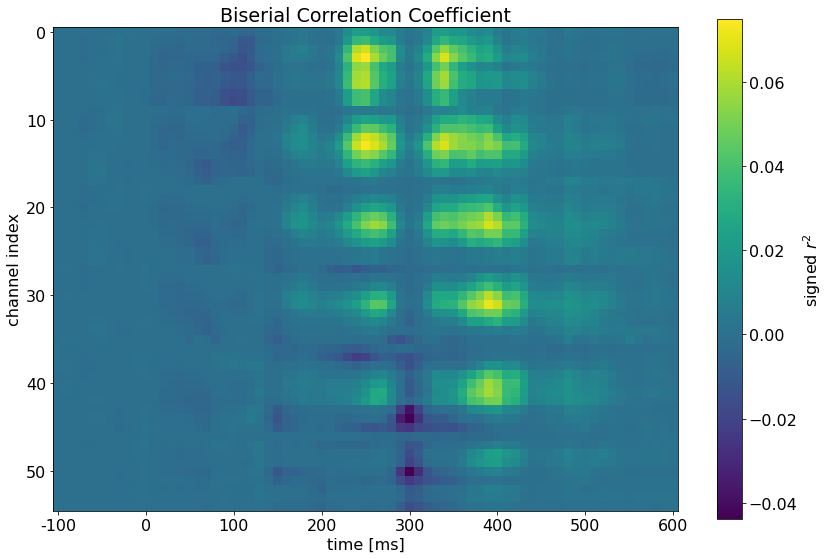

In [14]:
ival = [-100, 600]
ref_ival = [-100, 0]

# get the correct index values for the time steps
epo_t_idx = np.where(epo_t < ival[0], np.nan, epo_t) 
epo_t_idx = np.where(epo_t > ival[1], np.nan, epo_t_idx)
epo_t_idx = [i for i in range(len(epo_t_idx)) if ~np.isnan(epo_t_idx[i])]
    
# determine the epochs for the ival
epo, epo_t = bci.makeepochs(X=cnt, fs=fs, mrk_pos=mrk_pos, ival=ival)
baseline_epo = bci.baseline(epo=epo, epo_t=epo_t[epo_t_idx], ref_ival=ref_ival)

epo_r = signed_r_square(epo=baseline_epo, y=mrk_class)
time_range = np.linspace(ival[0], ival[1], np.shape(epo_r)[0])

fig = plt.figure(figsize=(12,8))
plt.imshow(epo_r.T) # , vmin=-0.04, vmax=0.04)
plt.title('Biserial Correlation Coefficient')
plt.xlabel('time [ms]')
plt.ylabel('channel index')
plt.xticks(np.linspace(0, np.shape(epo_r)[0]-1, 8), 
           np.linspace(ival[0], ival[1], 8, dtype=int))
plt.colorbar(label='signed $r^2$')
plt.tight_layout()
plt.show()